## This version uses the correct matrices in the linear equation. It however seems to give nearly indentical results to my previous version.

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd

In [3]:
x = np.arange(-16, 16, 1)
y = x.copy()
y0, x0 = np.meshgrid(x, y)
grid = np.dstack((y0, x0))

In [4]:
import scipy.stats

## see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html

def gaussian2d(grid, m=None, s=None):
    if m is None:
        m = [0., 0.]
    if s is None:
        s = [1., 1.]
    cov = [[s[0], 0], [0, s[1]]]
    var = scipy.stats.multivariate_normal(mean=m, cov=cov)
    return var.pdf(grid)

#g1 = gaussian2d(grid) + gaussian2d(grid, [5,5], [3,1])
#plt.imshow(g1)

Make the two "images". `im1` is the template, `im2` is the science image.

NOTE: having sources near the edges really messes up the fitting (probably because of the convolution). So make sure no sources are near the edge.

NOTE: also it seems that having the variable source with a large flux increase also messes up the fitting (seems to lead to overfitting -- perhaps to the source itself). This might be fixed by adding more constant sources.

In [5]:
np.random.seed(66)

xim = np.arange(-256, 256, 1)
yim = xim.copy()
y0im, x0im = np.meshgrid(xim, yim)
imgrid = np.dstack((y0im, x0im))
n_sources = 500
fluxes = np.random.uniform(50, 30000, n_sources)
xposns = np.random.uniform(xim.min()+16, xim.max()-5, n_sources)
yposns = np.random.uniform(yim.min()+16, yim.max()-5, n_sources)

# Make the source closest to the center of the image the one that increases in flux
ind = np.argmin(xposns**2. + yposns**2.)
print ind, xposns[ind], yposns[ind]

sig1 = 0.2  # sigma of template
sig2 = 0.2  # sigma of science image
im1 = np.random.normal(scale=sig1, size=x0im.shape)
im2 = np.random.normal(scale=sig2, size=x0im.shape)

psf1 = 1.6 # sigma in pixels im1 will be template
psf2 = 2.2 # sigma in pixels im2 will be science image. make the psf in this image slighly offset and elongated
print np.sqrt(psf2**2 - psf1**2)
offset = 0.2  # astrometric offset (pixels) between the two images
psf2_yvary = 0.2 + (yim.mean() - yposns) / yim.max() * 0.2  # variation in y-width of psf in science image across (x-dim of) image
psf2_yvary[:] = 0.2  # turn it off for now, just add a constant 1.1 pixel horizontal width
print scipy.stats.describe(psf2 + psf2_yvary)

for i in range(n_sources):
    flux = fluxes[i]
    im1 += flux * gaussian2d(imgrid, m=[xposns[i], yposns[i]], s=[psf1, psf1])
    if i == ind:
        flux += flux / 50.
    im2 += flux * gaussian2d(imgrid, m=[xposns[i]+offset, yposns[i]+offset], s=[psf2, psf2+psf2_yvary[i]])

# Add a (constant, for now) background offset to im2
#im2background = 10.
#im2 += im2background

print im1.shape
print scipy.stats.describe(im2 - im1, axis=None)

280 4.81591183536 -5.87310921947
1.50996688705
DescribeResult(nobs=500, minmax=(2.4000000000000004, 2.4000000000000004), mean=2.3999999999999995, variance=7.9044178879860894e-31, skewness=1.0, kurtosis=-2.0)
(512, 512)
DescribeResult(nobs=262144, minmax=(-1229.956254029179, 395.53812874929258), mean=1.793937560857703e-05, variance=1973.3830291264223, skewness=-8.4606484231629, kurtosis=123.5506839899728)


## Compute the FFTs for the "ZOGY" algorithm

In [6]:
from scipy.fftpack import fft2, ifft2, fftfreq, fftshift

DescribeResult(nobs=262144, minmax=(-0.92719462140093301, 3786.6816190269788), mean=28.094248089391261, variance=27692.835755683205, skewness=8.936290163148414, kurtosis=96.13517364965696)
DescribeResult(nobs=262144, minmax=(-0.92719462140093789, 3786.6816190269788), mean=28.094248089391257, variance=27692.835755683202, skewness=8.936290163148414, kurtosis=96.13517364965696)


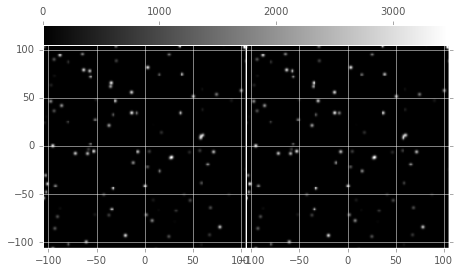

In [7]:
# First compute the science image's (im2's) psf -- easy since we parameterized it above when we made the image
im1_psf = gaussian2d(grid, m=[0, 0], s=[psf1, psf1])
im2_psf = gaussian2d(grid, m=[0, 0], s=[psf2, psf2*1.5])

im1_psf_ft = fft2(im1_psf)
im2_psf_ft = fft2(im2_psf)

im1_ft = fft2(im1)
im2_ft = fft2(im2)

# Just a sanity check:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(1, (8, 4))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.0, share_all=True, label_mode="L",
                    cbar_location="top", cbar_mode="single")
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[1].imshow(ifft2(im1_ft).real[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid.cbar_axes[0].colorbar(gim)
print scipy.stats.describe(im1, axis=None)
print scipy.stats.describe(ifft2(im1_ft).real, axis=None)

### Now compute the ZOGY eqn. (13):

$$
\widehat{D} = \frac{F_r\widehat{P_r}\widehat{N} - F_n\widehat{P_n}\widehat{R}}{\sqrt{\sigma_n^2 F_r^2 |\widehat{P_r}|^2 + \sigma_r^2 F_n^2 |\widehat{P_n}|^2}}
$$

where $D$ is the optimal difference image, $R$ and $N$ are the reference and "new" image, respectively, $P_r$ and $P_n$ are their PSFs, $F_r$ and $F_n$ are their flux-based zero-points (which we will set to one here), $\sigma_r^2$ and $\sigma_n^2$ are their variance, and $\widehat{D}$ denotes the FT of $D$.

DescribeResult(nobs=262144, minmax=(-1200.7076311888709, 1196.253582600787), mean=6.342527834440892e-05, variance=5329.7839941692382, skewness=-0.0035595022855473757, kurtosis=54.606887803746424)


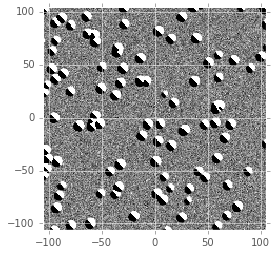

In [8]:
F_r = F_n = 1.
R_hat = fft2(im1)
N_hat = fft2(im2)
P_r = gaussian2d(imgrid, m=[0, 0], s=[psf1, psf1])
P_n = gaussian2d(imgrid, m=[0, 0], s=[psf2, psf2+0.2])
P_r_hat = fft2(P_r)
P_n_hat = fft2(P_n)
d_hat_numerator = (F_r * P_r_hat * N_hat - F_n * P_n_hat * R_hat)
d_hat_denom = np.sqrt((sig1**2 * F_r**2 * np.abs(P_r_hat)**2) + (sig2**2 * F_n**2 * np.abs(P_n_hat)**2))
d_hat = d_hat_numerator / d_hat_denom

d = ifft2(d_hat)
D = np.fft.ifftshift(d.real)
plt.imshow(D[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-4, 4))
print scipy.stats.describe(D, axis=None)

### Compute the PSF of the difference image D (eq. 14):

$$
\widehat{P_D} = \frac{F_r F_n \widehat{P_r} \widehat{P_n}}{F_D \sqrt{\sigma_n^2 F_r^2 |\widehat{P_r}|^2 + \sigma_r^2 F_n^2 |\widehat{P_n}|^2}}
$$

where

$$
F_D = \frac{F_r F_n}{\sqrt{\sigma_n^2 F_r^2 + \sigma_r^2 F_n^2}}
$$

DescribeResult(nobs=262144, minmax=(-2.3876346572588407e-05, 0.077663961984779872), mean=3.8146972656251474e-06, variance=1.5131062976682301e-07, skewness=133.81854375624698, kurtosis=20087.002698214572)


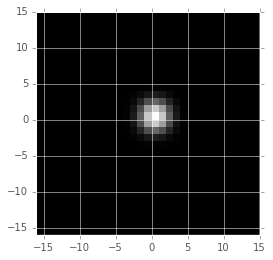

In [9]:
F_D_numerator = F_r * F_n
F_D_denom = np.sqrt(sig1**2 * F_r**2 + sig2**2 * F_n**2)
F_D = F_D_numerator / F_D_denom

P_d_hat_numerator = (F_r * F_n * P_r_hat * P_n_hat)
P_d_hat = P_d_hat_numerator / (F_D * d_hat_denom)

P_d = ifft2(P_d_hat)
P_D = np.fft.ifftshift(P_d.real)
extent = (x0im.min()+240, x0im.max()-240, y0im.min()+240, y0im.max()-240)
x1p, x2p, y1p, y2p = 240, 511-240, 240, 511-240   # limits for display
plt.imshow(P_D[x1p:x2p,y1p:y2p], origin='lower', interpolation='none', cmap='gray', extent=extent) #, clim=(0, 0.67))
print scipy.stats.describe(P_D, axis=None)

Dump the results for comparison with L(ZOGY) in notebook #13.